## NAME -Akash Singh
### Roll no. - 22101402

# Solution of faulkner-skan equations using 'Formulation - B'

#### Faulkner - Skan boundary layer equation:
$\begin{align}
f''' + \frac{(m+1)}{2}ff'' + m(1 - (f')^2) = 0
\end{align}$
where 
$$\eta  = y\left ( \sqrt\frac{U(x)}{\nu x} \right )$$
and
$$f'(\eta ) =\frac{u}{U(x)}$$
$$ U(x) = Kx^m $$

#### Boundary Conditions:
$$\eta = 0 : f(0) = f'(0) = 0$$
$$ \eta = 6 : f'(6) = 1 $$
$$ \eta = 6 : f''(6) = 0 $$
To represent infinity for computational purposes a sufficiently large number ($\eta = 6$) is taken 

### This is the implementation of solution of faulkner skan boundary layer equation using PIELM method

In [101]:
# importing neccery packages
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim 
import numpy as np   # Numpy
import matplotlib.pyplot as plt

In [102]:
#Creation of 1D array (representing data sampling)
np.random.seed(947)
torch.manual_seed(987)
eta = np.linspace(0,6,1000)[:,None]
eta_min = eta[[0]]
eta_max = eta[[-1]]

#ODE parametres

m = 1          # this value of m can be changed and results for different wedge angles can be generated.
k = 1
nu = 1.48e-5    # kinematic viscosity of air

bc = eta[[0,-1]]
f_bc = np.array([[0],
                [1]])

In [103]:
eta = torch.from_numpy(eta).float()
eta_min = torch.from_numpy(eta_min).float()
eta_max = torch.from_numpy(eta_max).float()
bc = torch.from_numpy(bc).float()
f_bc = torch.from_numpy(f_bc).float()

### Loss function formulation for PIELM :
#### Boundary Loss :
$$e_{bc1} = f(0) = 0$$
$$e_{bc2} = f'(0) = 0$$
$$e_{bc3} = f'(6)-1 = 0$$
$$e_{bc4} = f''(6) = 0$$
$e_{bc} = e_{bc1}^2+e_{bc2}^2+e_{bc3}^2+e_{bc4}^2$

#### ODE loss : 
$$e_{ode} = \frac{1}{N}\sum_{i=1}^{N}\left ( f''' +\frac{(m+1)}{2}ff''+m(1-(f')^2) \right )^2$$

#### Total Loss :
$$e_{total} = e_{bc} + e_{ode}$$

#### Now this total composite Loss function is optimised to get the weights (C) between hidden layer and output layer

#### Automatic Differentiation is used to compute derivatives for optimization of loss function , in order to get weights between hidden layer and output layer (C)

In [104]:
class PIELM(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # defining the activation function
        self.activation = nn.Tanh()

        #defining the loss function
        self.loss_function = nn.MSELoss(reduction='mean')

       
        self.fc1 =nn.Linear(1,hidden_size)
        self.fc2 = nn.Linear(hidden_size,1,bias = False)   # No bias in between hidden layer and output layer.

        self.iter = 0


        self.Lbc = []
        self.Lpde = []


    def forward(self,x):

        # A check if input data is not in tensor form
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)

        # min - max scaling of the data 
        x = (x -eta_min)/(eta_max-eta_min)

        
        z = self.fc1(x)
        a = self.activation(z)

        f = self.fc2(a)
        return f

    def bc_loss(self,x,y):
        
        # BC1
        x1 = x[[0]]
        y1 = y[[0]]

        g1 = x1.clone()
        g1.requires_grad = True
        f1 = self.forward(g1)
        f_etab1 = autograd.grad(f1,g1,torch.ones([x1.shape[0],1]),retain_graph = True,create_graph = True)[0]

        #BC2
        x2 = x[[1]]
        y2 = y[[1]]
        g2 = x2.clone()
        g2.requires_grad = True
        f2 = self.forward(g2)
        f_etab2 = autograd.grad(f2,g2,torch.ones([x2.shape[0],1]),retain_graph = True,create_graph = True)[0]

        loss_bc1 = self.loss_function(f1,y1) + self.loss_function(f_etab1,torch.zeros_like(f_etab1))
        loss_bc2 = self.loss_function(f_etab2,y2)
        loss_bc = loss_bc1 + loss_bc2
        self.Lbc.append(loss_bc.item())
        return loss_bc
    
    def PDE(self,x):
        g3 = x.clone()
        g3.requires_grad = True
        f3 = self.forward(g3)

        f_eta = autograd.grad(f3,g3,torch.ones([g3.shape[0],1]),retain_graph = True,create_graph = True)[0]
        f_eta2 = autograd.grad(f_eta,g3,torch.ones([g3.shape[0],1]),retain_graph = True,create_graph = True)[0]
        f_eta3 = autograd.grad(f_eta2,g3,torch.ones([g3.shape[0],1]),create_graph = True)[0]

        # defining faulkner skan ordinary differential equation
        
        pde = f_eta3 + ((m+1)/2) * f3*f_eta2 + m*(1 -(f_eta)**2)

        loss_pde = self.loss_function(pde,torch.zeros_like(pde))
        self.Lpde.append(loss_pde.item())
        return loss_pde
    
    # composite loss function to be optimised for PIELM to get C
    def loss(self,x,xb,yb):

        loss1= self.bc_loss(xb,yb)
        loss2 = self.PDE(x)

        total_loss = abs(loss1) + abs(loss2)
        return total_loss
    
    def closure(self):
        optimizer_pin.zero_grad()

        loss = self.loss(eta,bc,f_bc)

        loss.backward()

        self.iter += 1

        if self.iter % 100 ==0:
            print(loss)
            
        return loss    
    
    def test(self,x):
        x.requires_grad = True
        pred_result = self.forward(x)
        f_d = autograd.grad(pred_result,x,torch.ones([x.shape[0],1]),retain_graph = True,create_graph = True)[0]
        f_dd = autograd.grad(f_d,x,torch.ones([x.shape[0],1]),retain_graph = True,create_graph = True)[0]

        pred_result = pred_result.detach().numpy()
        f_d = f_d.detach().numpy()
        f_dd = f_dd.detach().numpy()


        return pred_result,f_d,f_dd

### Architectural choices (PIELM) :

#### Activation function chosen : Tanh
#### Loss reduction method : MSEloss
#### no. of neurons in hidden layer = 300

In [105]:
# specification of hidden layer
hidden_size = 300

#creating an instance of PIELM class
pielm = PIELM()

pielm.fc1.weight.requires_grad = False   # keeping the weights between input layer and hidden layer untrained
pielm.fc1.bias.requires_grad = False     # keeping the bias between input layer and hidden layer untrained

#params0 = list(pielm.parameters())


optimizer_pin = torch.optim.LBFGS(pielm.parameters(),lr = 0.1,max_iter = 2000,
                              tolerance_grad = 1e-10,tolerance_change=1e-10,
                              history_size = 800,line_search_fn='strong_wolfe')

optimizer_pin.step(pielm.closure)

tensor(0.0985, grad_fn=<AddBackward0>)


tensor(1.9542, grad_fn=<AddBackward0>)

### Formulation of loss functions (PINNS) :
#### Boundary losses :
$$e_{bc1} = f(0)^2$$
$$e_{bc2} = f'(0)^2$$
$$e_{bc3} = (f'(6)-1)^2$$
$$e_{bc4} = f''(6)^2$$
$e_{bc} = e_{bc1}+e_{bc2}+e_{bc3}+e_{bc4}$

Since we have only one boundary point on either side of the domain , summantion is not used 

#### ODE Loss :
$$e_{ode} = \frac{1}{N}\sum_{i=1}^{N}\left ( f''' +\frac{(m+1)}{2}ff''+m(1-(f')^2) \right )^2$$

where N = no. of point sampled inside 1D domain
for this problem N = 1000

#### Total loss :
$$e_{total} = e_{bc} + e_{ode}$$

In [106]:
class PINN(nn.Module):
    
    def __init__(self,layers):
        super().__init__()
        
        # definning the activation function
        self.activation = nn.Tanh()

        #defining the loss function
        self.loss_function = nn.MSELoss(reduction='mean')

        # defining the list of linear transformation objects which neural network applies between each layers
        self.linears = nn.ModuleList([nn.Linear(layers[i],layers[i+1]) for i in range(len(layers)-1)])

        self.iter = 0

        self.Lbc = []
        self.Lpde = []


    def forward(self,x):

        # A check if input data is not in tensor form
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)

        # min - max scaling of the data 
        x = (x -eta_min)/(eta_max-eta_min)

        for i in range(len(layers)-2):
            z = self.linears[i](x)
            x = self.activation(z)

        a = self.linears[-1](x)
        return a

    def bc_loss(self,x,y):
        
        # BC1
        x1 = x[[0]]
        y1 = y[[0]]

        g1 = x1.clone()
        g1.requires_grad = True
        f1 = self.forward(g1)
        f_etab1 = autograd.grad(f1,g1,torch.ones([x1.shape[0],1]),retain_graph = True,create_graph = True)[0]

        #BC2
        x2 = x[[1]]
        y2 = y[[1]]
        g2 = x2.clone()
        g2.requires_grad = True
        f2 = self.forward(g2)
        f_etab2 = autograd.grad(f2,g2,torch.ones([x2.shape[0],1]),retain_graph = True,create_graph = True)[0]

        loss_bc1 = self.loss_function(f1,y1) + self.loss_function(f_etab1,torch.zeros_like(f_etab1))
        loss_bc2 = self.loss_function(f_etab2,y2)
        loss_bc = loss_bc1 + loss_bc2
        self.Lbc.append(loss_bc.item())
        return loss_bc
    
    def PDE(self,x):
        g3 = x.clone()
        g3.requires_grad = True
        f3 = self.forward(g3)

        f_eta = autograd.grad(f3,g3,torch.ones([g3.shape[0],1]),retain_graph = True,create_graph = True)[0]
        f_eta2 = autograd.grad(f_eta,g3,torch.ones([g3.shape[0],1]),retain_graph = True,create_graph = True)[0]
        f_eta3 = autograd.grad(f_eta2,g3,torch.ones([g3.shape[0],1]),create_graph = True)[0]

        # defining faulkner skan ordinary differential equation
        
        pde = f_eta3 + ((m+1)/2) * f3*f_eta2 + m*(1 -(f_eta)**2)

        loss_pde = self.loss_function(pde,torch.zeros_like(pde))
        self.Lpde.append(loss_pde.item())
        return loss_pde
    
    def loss(self,x,xb,yb):

        loss1= self.bc_loss(xb,yb)
        loss2 = self.PDE(x)

        total_loss = abs(loss1) + abs(loss2)
        return total_loss
    
    def closure(self):
        optimizer.zero_grad()

        loss = self.loss(eta,bc,f_bc)

        loss.backward()

        self.iter += 1

        if self.iter % 100 ==0:
            print(loss)
            
        return loss    
    
    def test(self,x):
        x.requires_grad = True
        pred_result = self.forward(x)
        f_d = autograd.grad(pred_result,x,torch.ones([x.shape[0],1]),retain_graph = True,create_graph = True)[0]
        f_dd = autograd.grad(f_d,x,torch.ones([x.shape[0],1]),retain_graph = True,create_graph = True)[0]

        pred_result = pred_result.detach().numpy()
        f_d = f_d.detach().numpy()
        f_dd = f_dd.detach().numpy()


        return pred_result,f_d,f_dd

### Architectural choices (PINN) :

#### Activation function chosen : Tanh
#### Loss reduction method : MSEloss
#### no. of neurons in hidden layer = 20 (decided after multiple experimentation , after 20 neurons there is no significant changes in loss )

In [107]:
# specification of network architecture
layers = [1,20,1]

#creating an instance of NN class
pinn = PINN(layers)

params_pin = list(pinn.parameters())

optimizer = torch.optim.LBFGS(pinn.parameters(),lr = 0.1,max_iter = 2000,
                              tolerance_grad = 1e-7,tolerance_change=1e-10,
                              history_size = 500,line_search_fn='strong_wolfe')

optimizer.step(pinn.closure)

tensor(0.0104, grad_fn=<AddBackward0>)
tensor(6.5306e-05, grad_fn=<AddBackward0>)
tensor(2.4779e-05, grad_fn=<AddBackward0>)
tensor(5.1510e-06, grad_fn=<AddBackward0>)


tensor(2.0047, grad_fn=<AddBackward0>)

173


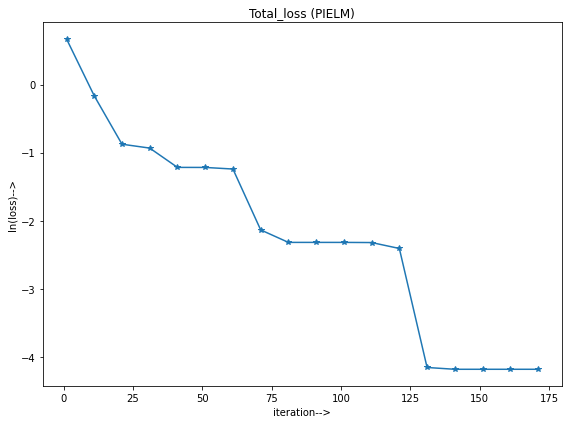

0.015277169295586646


In [108]:
print(pielm.iter)
bcloss_pielm = pielm.Lbc
pdeloss_pielm = pielm.Lpde

plt.figure(figsize = (8,6))
#plt.subplot(121)
#plt.plot(np.arange(1,len(Lbc_list)+1)[::10],np.log(np.array(Lbc_list)[::10]),marker = '*',label = 'boundary_loss')
#plt.plot(np.arange(1,len(Lpde_list)+1)[::10],np.log(np.array(Lpde_list)[::10]),marker = 'o',label = 'pde_loss')
#plt.legend()
#plt.xlabel('iteration-->')
#plt.ylabel('ln(loss)-->')
#plt.title('Indivisual_loss')

#plt.subplot(122)
totalloss_pielm = [a + b for a, b in zip(bcloss_pielm, pdeloss_pielm)]
plt.plot(np.arange(1,len(totalloss_pielm)+1)[::10],np.log(np.array(totalloss_pielm)[::10]),marker ='*')
plt.title('Total_loss (PIELM)')
plt.xlabel('iteration-->')
plt.ylabel('ln(loss)-->')
plt.tight_layout()
#plt.savefig(f'Loss({layers[1]}).png')
plt.show()

error_pielm = abs(totalloss_pielm[-1])
print(error_pielm)
fp_pielm,fpd_pielm,fpdd_pielm = pielm.test(eta)

470


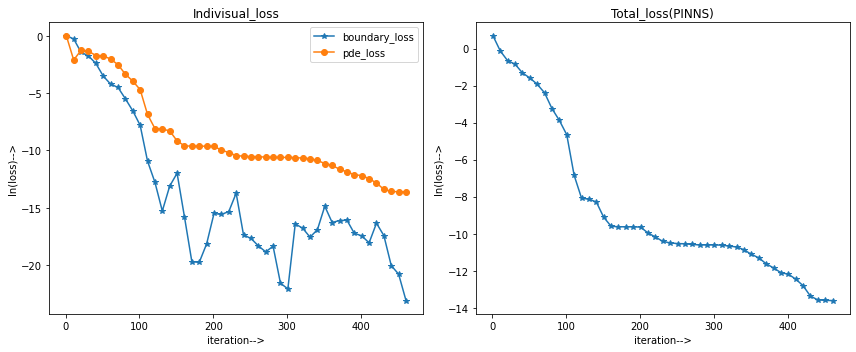

1.230706145924354e-06


In [109]:
print(pinn.iter)
bcloss_pinn = pinn.Lbc
pdeloss_pinn = pinn.Lpde

plt.figure(figsize = (12,5))
plt.subplot(121)
plt.plot(np.arange(1,len(bcloss_pinn)+1)[::10],np.log(np.array(bcloss_pinn)[::10]),marker = '*',label = 'boundary_loss')
plt.plot(np.arange(1,len(pdeloss_pinn)+1)[::10],np.log(np.array(pdeloss_pinn)[::10]),marker = 'o',label = 'pde_loss')
plt.legend()
plt.xlabel('iteration-->')
plt.ylabel('ln(loss)-->')
plt.title('Indivisual_loss')

plt.subplot(122)
totalloss_pinn = [a + b for a, b in zip(bcloss_pinn, pdeloss_pinn)]
plt.plot(np.arange(1,len(totalloss_pinn)+1)[::10],np.log(np.array(totalloss_pinn)[::10]),marker ='*')
plt.title('Total_loss(PINNS)')
plt.xlabel('iteration-->')
plt.ylabel('ln(loss)-->')
plt.tight_layout()
#plt.savefig(f'Loss({layers[1]}).png')
plt.show()

error_pinn = abs(totalloss_pinn[-1])
print(error_pinn)
fp_pinn,fpd_pinn,fpdd_pinn = pinn.test(eta)

#### one main difference observed in training PIELM and PINN is , PIELM is faster in training as compared to PINNS (i.e converged in lesser iterations)

In [110]:
eta = eta.detach().numpy()
fp_pielm = fp_pielm[:,0]
fpd_pielm = fpd_pielm[:,0]
fpdd_pielm = fpdd_pielm[:,0]
fp_pinn = fp_pinn[:,0]
fpd_pinn = fpd_pinn[:,0]
fpdd_pinn = fpdd_pinn[:,0]
eta = eta[:,0]

In [111]:
if m ==0:
    Lxfd = [0, 4.552160519570624, 3.066385984263268, 2.7502637427085115, 2.4088516253565224, 1.1570073558539828, 0.6512120105485026, 0.2212855690883295, 0.44889372771703223, 0.9167545005087937, 1.7702847938887667, 2.067439508004534, 1.4604849006922533, 3.83772406071117, 5.608008613417806, 3.445732674128976, 4.172813829704915, 4.893572636922612, 5.253952281713591, 5.987355303283514]
    Lyfd = [0, 0.9751243793683977, 0.8557214509462848, 0.8026532578272146, 0.7363182694762745, 0.3847431348737711, 0.22553906161235535, 0.07960228967860679, 0.1525706756454806, 0.3117747489068963, 0.5704807985989241, 0.6500830882775309, 0.4776122197842463, 0.9485905358567606, 1.0016579698321355, 0.908789391017458, 0.9684904756566657, 0.9950250783119986, 1.0016579698321355, 1.0082918735438675]

    Lxf = [0, 0.22712925402447556, 0.504731889543208, 0.7760252320376988, 1.1419560444964605, 1.533123066352511, 1.9305996219077235, 2.30914853906513, 2.7444794087162743, 3.1608836026692932, 3.5331229861275375, 3.880126160188493, 4.2586750773459, 4.624605889804661, 4.971609063865618, 5.305993651878089, 5.627760616541755, 5.993691429000518]
    Lyf = [0, 0.01326730132766719, 0.039800891791404, 0.09950248252641035, 0.22553906161235535, 0.40464332772157463, 0.63018238933393, 0.8756221498898867, 1.174129344421218, 1.5323378766396556, 1.8573799268742182, 2.189054868628918, 2.5737977504547906, 2.9253731381051926, 3.2570480798598926, 3.608623467510295, 3.93366501164906, 4.305140908457139]

    Lxfdd = [0, 0.2776023948438126, 0.5804414804347537, 0.858044115953486, 1.173501787592911, 1.5078863756053829, 1.835962392618372, 2.1703469806308435, 2.485804411595349, 2.8706623811020777, 3.217665555163032, 3.5962144723204386, 3.955836232429878, 4.359621840334413, 4.694006428346884, 5.034701031408358, 5.444795691662215, 5.987381895301356]
    Lyfdd = [0.3316749417546999, 0.3316749417546999, 0.3316749417546999, 0.32504154413876474, 0.3117747489068963, 0.2918740499632959, 0.2719733510196945, 0.24543976055595673, 0.21890566399642114, 0.1791047722050162, 0.13930337431781434, 0.09950248252641035, 0.059701590735005396, 0.03316749417547075, 0.0265340965595356, 0.01326730132766719, 0.01326730132766719, 0.01326730132766719]

elif m ==1:
    Lxf = [0.12863529640174673, 0.25167783731426574, 0.4921699503001302, 0.7829979294387724, 1.0961969305343244, 1.3926172384623017, 1.733780870403776, 2.0469798714993277, 2.410514525397711, 2.7069348333256884, 3.087248180391647, 3.406039936976426, 3.7472035689179006, 4.071588080991908, 4.591722448788012]
    Lyf = [0.011363896056385468, 0.034090821192534024, 0.13636371825844526, 0.29545479514134987, 0.5284092456933586, 0.7897727861538637, 1.107954506431362, 1.403409084828556, 1.7613637910709345, 2.0568181527239737, 2.437500000846657, 2.75568193786831, 3.09659090839819, 3.426136416359995, 3.9431818201830073]

    Lxfd = [0, 0.17337798036540444, 0.4194630621904427, 0.7046980724899115, 1.0626399708990677, 1.4429528912651335, 1.7729305855282598, 2.1923936477187023, 2.6621923627119766, 3.0592839762456174, 3.406039936976426, 3.7416103867287807, 4.082774018670254, 4.435122734890291, 4.692393754393676, 4.988814489021546]
    Lyfd = [0.0056817312840377445, 0.19886362935947555, 0.42613634862744737, 0.6306817092709599, 0.8011362487219383, 0.9034091457878491, 0.9602273256048421, 0.9829546842293014, 0.9943181467973762, 0.9999998780814131, 0.9999998780814131, 0.9999998780814131, 0.9943181467973762, 0.9943181467973762, 1.0056820428537607, 0.9999998780814131]
    
    Lxfdd = [0, 0.26286356164266667, 0.4921699503001302, 0.7885906849280001, 1.157718094315611, 1.4429528912651335, 1.8176734828418646, 2.225950607353959, 2.5391496084495118, 2.7628632416177483, 2.9306484664939245, 3.143176588683706, 3.4451900788008034, 3.7192393647718704, 4.060402570013452, 4.379194326598231, 4.703579265372131, 5]
    Lyfdd = [1.2272723806052295, 0.9829546842293014, 0.7670454275294043, 0.5340909769773956, 0.3124999889934615, 0.19318189807543862, 0.0965911657818743, 0.03977298596488174, 0.02272735862445934, 0.017045627340422403, 0.011363896056385468, 0.0056817312840377445, 0, 0, 0, 0, 0, 0.0056817312840377445]

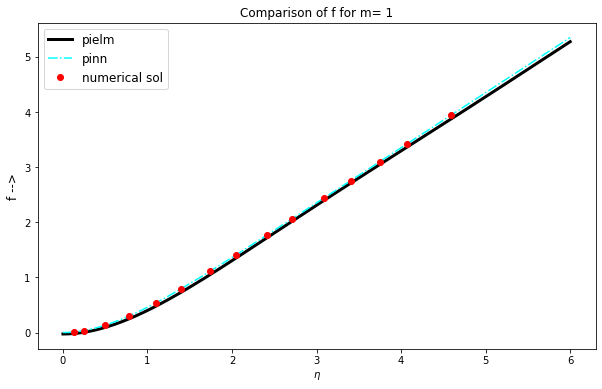

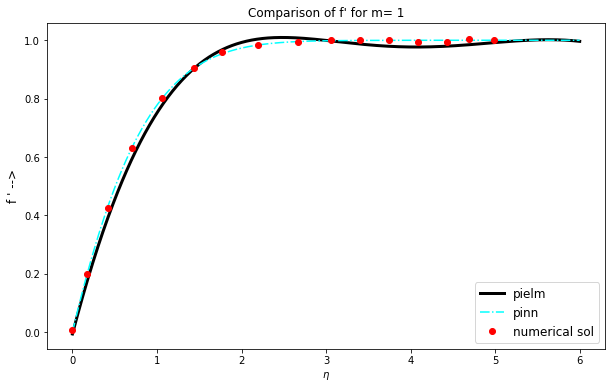

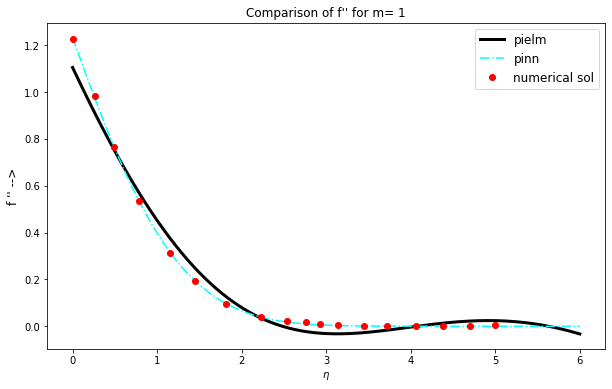

In [112]:
plt.figure(figsize =(10,6))
plt.plot(eta,fp_pielm,label = 'pielm',c = 'black',linewidth = 3)
plt.plot(eta,fp_pinn,linestyle = '-.',label = 'pinn',c = 'cyan',linewidth = 1.5)
plt.plot(Lxf,Lyf,"or",label = 'numerical sol')
plt.legend(fontsize = 12)
plt.title(f"Comparison of f for m= {m}")
plt.ylabel("f -->",fontsize = 12)
plt.xlabel('$\eta$')
plt.show()

plt.figure(figsize =(10,6))
plt.plot(eta,fpd_pielm,label ="pielm",c='black',linewidth = 3)
plt.plot(eta,fpd_pinn,linestyle ='-.',label ="pinn",c='cyan',linewidth = 1.5)
plt.plot(Lxfd,Lyfd,"or",label = 'numerical sol')
plt.legend(fontsize = 12)
plt.title(f"Comparison of f' for m= {m}")
plt.ylabel("f ' -->",fontsize = 12)
plt.xlabel('$\eta$')
plt.show()

plt.figure(figsize =(10,6))
plt.plot(eta,fpdd_pielm,label = "pielm",c = "black",linewidth = 3)
plt.plot(eta,fpdd_pinn,linestyle ='-.',label ="pinn",c='cyan',linewidth = 1.5)
plt.plot(Lxfdd,Lyfdd,"or",label = 'numerical sol')
plt.legend(fontsize = 12)
plt.title(f"Comparison of f'' for m= {m}")
plt.xlabel('$\eta$')
plt.ylabel("f '' -->",fontsize = 12)
plt.show()




In [113]:
# defining local reynolds number
x_r = np.linspace(1e-3,0.5,1000)

Re_x = (k*(x_r**m)*x_r)/nu

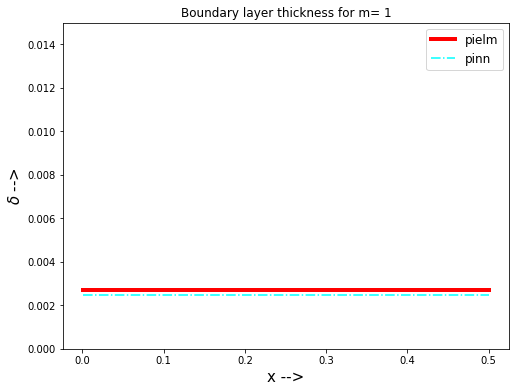

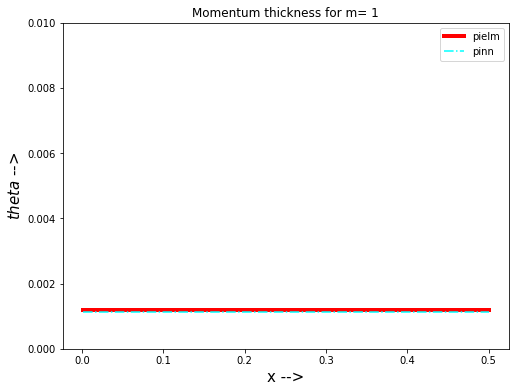

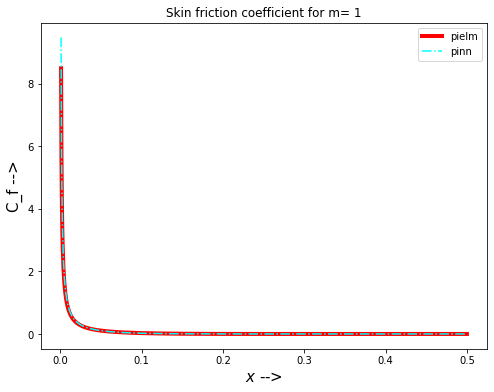

In [114]:
int_delta_pielm = np.trapz((1-fpd_pielm), eta)

delta_pielm = x_r*np.sqrt(1/Re_x)*int_delta_pielm   # boundary layer thickness predicted by pielm

int_delta_pinn = np.trapz((1-fpd_pinn), eta)

delta_pinn = x_r*np.sqrt(1/Re_x)*int_delta_pinn      # boundary layer thickness predicted by pinn

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(x_r,delta_pielm ,c="r", linewidth = 4 ,label = 'pielm')
ax.plot(x_r,delta_pinn ,c="cyan",linestyle ='-.', linewidth = 1.5 ,label = 'pinn')
ax.set_xlabel("x -->",fontsize = 15)
ax.set_title(f'Boundary layer thickness for m= {m}')
ax.legend(fontsize = 12)
ax.set_ylim(0,0.015)
ax.set_ylabel('$\delta$ -->',fontsize = 15)
plt.show()

int_theta_pielm = np.trapz((fpd_pielm*(1-fpd_pielm)), eta)

theta_pielm = x_r*np.sqrt(1/Re_x)*int_theta_pielm         # momentum thickness predicted by pielm

int_theta_pinn = np.trapz((fpd_pinn*(1-fpd_pinn)), eta)

theta_pinn = x_r*np.sqrt(1/Re_x)*int_theta_pinn           # momentum thickness predicted by pinns

fig,ax = plt.subplots(figsize = (8,6))
ax.plot(x_r,theta_pielm,c="r", linewidth = 4 ,label = 'pielm')
ax.plot(x_r,theta_pinn ,c="cyan",linestyle ='-.', linewidth = 1.5 ,label = 'pinn')
ax.set_xlabel("x -->",fontsize = 15)
ax.set_title(f'Momentum thickness for m= {m}')
ax.set_ylabel('$theta$ -->',fontsize = 15)
ax.legend()
ax.set_ylim(0,0.01)
plt.show()

cf_pielm = (2*fpdd_pielm)/np.sqrt(Re_x)             # Skin fiction coefficient predicted by pielm

cf_pinn = (2*fpdd_pinn)/np.sqrt(Re_x)               # Skin fiction coefficient predicted by pinn

plt.figure(figsize = (8,6))
plt.plot(x_r,cf_pielm,c="r", linewidth = 4 ,label = 'pielm')
plt.plot(x_r,cf_pinn,c="cyan",linestyle ='-.', linewidth = 1.5 ,label = 'pinn')
plt.xlabel("$x$ -->",fontsize = 15)
plt.title(f'Skin friction coefficient for m= {m}')
plt.legend()
plt.ylabel('C_f -->',fontsize = 15)
plt.show()


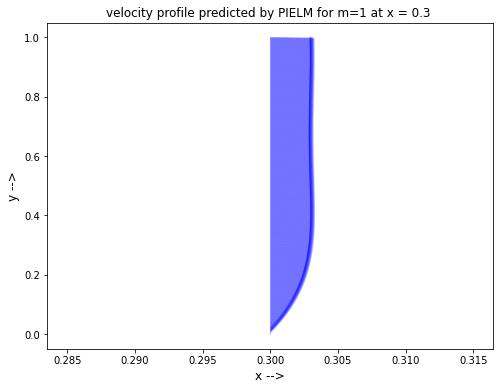

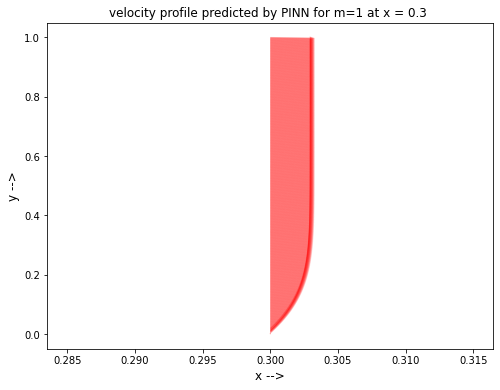

In [115]:
x_vel = 0.3
y_vel = np.linspace(0,1,1000)


u_pielm = k*x_vel**m*fpd_pielm

v_pielm = (-1*(((m+1)/2)*nu*k*x_vel**(m-1))**0.5)*(fpd_pielm + ((m-1)/(m+1))*eta*fpd_pielm)

u_pinn = k*x_vel**m*fpd_pinn

v_pinn = (-1*(((m+1)/2)*nu*k*x_vel**(m-1))**0.5)*(fpd_pinn + ((m-1)/(m+1))*eta*fpd_pinn)

plt.figure(figsize = (8,6))
plt.quiver(np.ones(1000)*x_vel, y_vel, u_pielm, v_pielm, scale=3, color='b', alpha=0.2)
plt.title(f"velocity profile predicted by PIELM for m={m} at x = {x_vel} ")
plt.xlabel('x -->',fontsize = 12)
plt.ylabel('y -->',fontsize = 12)
plt.show()
plt.figure(figsize = (8,6))
plt.quiver(np.ones(1000)*x_vel, y_vel, u_pinn, v_pinn, scale=3, color='r', alpha=0.2)
plt.title(f"velocity profile predicted by PINN for m={m} at x = {x_vel} ")
plt.xlabel('x -->',fontsize = 12)
plt.ylabel('y -->',fontsize = 12)
plt.show()